In [2]:
# load paths and classes from src
import os
import sys
from pathlib import Path

# Get the project root directory (one level up from notebooks)
# Use os.getcwd() since __file__ is not available in Jupyter notebooks
_current_dir = Path(os.getcwd())
_project_root = _current_dir.parent if _current_dir.name == "notebooks" else _current_dir
_src_path = _project_root / "src"
_data_path = _src_path / "data"
_models_path = _src_path / "models"

# Add paths to sys.path for imports
for path in [_src_path, _data_path, _models_path]:
    path_str = str(path)
    if path_str not in sys.path:
        sys.path.append(path_str)

print(f"✅ Added paths:")
print(f"   📁 src: {_src_path}")
print(f"   📁 data: {_data_path}")  
print(f"   📁 models: {_models_path}")

# Verify paths exist
for name, path in [("src", _src_path), ("data", _data_path), ("models", _models_path)]:
    if path.exists():
        print(f"   ✅ {name} directory exists")
    else:
        print(f"   ❌ {name} directory not found at {path}")

# Now you can import from these directories
# Example imports:
# from dataset import MCPTennisDataset
# from models import SimpleUnifiedBaseline  

✅ Added paths:
   📁 src: g:\Università\Computer Science\Foundations of Data Science\Tennis-Shot-Prediction\src
   📁 data: g:\Università\Computer Science\Foundations of Data Science\Tennis-Shot-Prediction\src\data
   📁 models: g:\Università\Computer Science\Foundations of Data Science\Tennis-Shot-Prediction\src\models
   ✅ src directory exists
   ✅ data directory exists
   ✅ models directory exists


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.class_weight import compute_class_weight
import re
import os
import random

# --- CONFIGURAZIONE GLOBALE ---
SEQ_LEN = 30       # Fixed sequence length
BATCH_SIZE = 64
EPOCHS = 10
LR = 1e-3
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the path
save_path = 'tennis_shot_forecasting.pth'

# Seed everything to avoid randomness
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    print(f"Random seed set to {seed}")

# Call it immediately
seed_everything(42)

Random seed set to 42


In [4]:
#load datasets
from dataset import MCPTennisDataset, EnhancedTennisDataset, MCPMultiTaskDataset, HierarchicalTennisDataset
from torch.utils.data import DataLoader

base_path = '../dataset/tennis_MatchChartingProject-master/'

# List all point files to merge
point_files = [
    base_path + 'charting-m-points-2020s.csv',
    base_path + 'charting-m-points-2010s.csv',
    base_path + 'charting-m-points-to-2009.csv'
]

# New Matches File
matches_path = base_path  + '/charting-m-matches.csv'

atp_path = '../dataset/atp_players.csv'
wta_path = '../dataset/wta_players.csv'

datasetSingleBaseline = MCPTennisDataset(point_files, matches_path, atp_path, wta_path, max_seq_len=SEQ_LEN) 
datasetSingleModel1 = MCPTennisDataset(point_files, matches_path, atp_path, wta_path, max_seq_len=SEQ_LEN) 
datasetSingleModel2 = EnhancedTennisDataset(
        points_paths_list=point_files,
        matches_path=matches_path,
        atp_path=atp_path,
        wta_path=wta_path,
        max_seq_len=SEQ_LEN  # Length of rally history to look at
    )
datasetMultiBaseline = MCPMultiTaskDataset(point_files, matches_path, atp_path, wta_path, max_seq_len=SEQ_LEN) 
datasetMultiModel = HierarchicalTennisDataset(point_files, matches_path, atp_path, wta_path, max_seq_len=SEQ_LEN) 


Initializing Dataset with FULL-SPEC Parsing Logic...


g:\Università\Computer Science\Foundations of Data Science\Tennis-Shot-Prediction\src\data\dataset.py:99: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')
g:\Università\Computer Science\Foundations of Data Science\Tennis-Shot-Prediction\src\data\dataset.py:99: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')


Parsing Rallies into Unified Tokens (FULL spec)...
Dataset Built. Unique Unified Shots Found: 4406
Initializing Dataset with FULL-SPEC Parsing Logic...


g:\Università\Computer Science\Foundations of Data Science\Tennis-Shot-Prediction\src\data\dataset.py:99: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')
g:\Università\Computer Science\Foundations of Data Science\Tennis-Shot-Prediction\src\data\dataset.py:99: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')


Parsing Rallies into Unified Tokens (FULL spec)...
Dataset Built. Unique Unified Shots Found: 4406
Initializing Dataset with FULL-SPEC Parsing Logic...


g:\Università\Computer Science\Foundations of Data Science\Tennis-Shot-Prediction\src\data\dataset.py:99: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')
g:\Università\Computer Science\Foundations of Data Science\Tennis-Shot-Prediction\src\data\dataset.py:99: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')


Parsing Rallies into Unified Tokens (FULL spec)...
Dataset Built. Unique Unified Shots Found: 4406
Decomposing inputs for Rich Embeddings...


g:\Università\Computer Science\Foundations of Data Science\Tennis-Shot-Prediction\src\data\dataset.py:630: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')
g:\Università\Computer Science\Foundations of Data Science\Tennis-Shot-Prediction\src\data\dataset.py:630: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')


Parsing Rallies for Multi-Task Learning...
Data Ready. Samples: 962968
Initializing Dataset with FULL-SPEC Parsing Logic...


g:\Università\Computer Science\Foundations of Data Science\Tennis-Shot-Prediction\src\data\dataset.py:99: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')
g:\Università\Computer Science\Foundations of Data Science\Tennis-Shot-Prediction\src\data\dataset.py:99: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding='utf-8', on_bad_lines='skip')


Parsing Rallies into Unified Tokens (FULL spec)...
Dataset Built. Unique Unified Shots Found: 4406
Decomposing Data for Hierarchical Training...


In [31]:
import importlib
import sys

# Import utils directly and reload it
if 'models.utils' in sys.modules:
    importlib.reload(sys.modules['models.utils'])
else:
    # First time import - try direct import from utils
    try:
        import models.utils
        importlib.reload(models.utils)
    except:
        # Fallback: import directly from the utils module
        import utils
        importlib.reload(utils)

# Import functions - try both approaches
try:
    from models.utils import (
        load_unified_lstm,
        load_rich_lstm,
        load_multi_baseline_model,
        load_checkpoint_single_baseline,
        load_hierarchical_checkpoint
    )
except ImportError:
    # Fallback to direct utils import
    from utils import (
        load_unified_lstm,
        load_rich_lstm,
        load_multi_baseline_model,
        load_checkpoint_single_baseline,
        load_hierarchical_checkpoint
    )

print("✅ Functions imported successfully from utils module")

device = "cuda" if torch.cuda.is_available() else "cpu"

# Try alternative loading approach to avoid torch._utils error
try:
    singleBaseline = load_checkpoint_single_baseline(
        filepath="../checkpoints/single_head_baseline.pth", 
        dataset=datasetSingleBaseline,
        device=device
    )
except Exception as e1:
    print(f"⚠️ Primary load failed: {e1}")
    try:
        # Fallback: try different checkpoint path
        singleBaseline = load_checkpoint_single_baseline(
            filepath="../checkpoints/singlehead_best.pt", 
            dataset=datasetSingleBaseline,
            device=device
        )
    except Exception as e2:
        print(f"⚠️ Fallback load also failed: {e2}")
        print("❌ SingleBaseline model could not be loaded")
        singleBaseline = None

singleModel1 = load_unified_lstm(datasetSingleModel1, checkpoint_path="../checkpoints/unified_lstm_model.pth", device=device)
singleModel2, optimizer, ckpt = load_rich_lstm(
    checkpoint_path="../checkpoints/rich_lstm_best.pt",
    dataset=datasetSingleModel2,        # optional but recommended
    device=device,
    load_optimizer=False    # True only if resuming training
)
multiBaseline, optimizer, ckpt = load_multi_baseline_model(
    checkpoint_path="../checkpoints/baseline_multi_best.pt",
    dataset=datasetMultiBaseline,       # optional but recommended for inference
    device=device,
    load_optimizer=False
)
multiModel = load_hierarchical_checkpoint(
    checkpoint_path="../checkpoints/hierarchical_best.pth",
    dataset=datasetMultiModel,      
    device=device,
    load_optimizer=False,
    load_scheduler=False
)

✅ Functions imported successfully from utils module
Loading checkpoint from '../checkpoints/single_head_baseline.pth'...
Model loaded successfully (Epoch 11)
✅ Unified LSTM loaded from ../checkpoints/unified_lstm_model.pth
✅ RichInputLSTM loaded from ../checkpoints/rich_lstm_best.pt
   Epoch: 15 | Val Acc: 24.01%
📦 Vocabularies restored into dataset
✅ Baseline model loaded from ../checkpoints/baseline_multi_best.pt
   Epoch: 12 | Type: 56.78% | Dir: 44.58% | Depth: 73.48%
📦 Vocabularies restored into dataset
📂 Loading checkpoint from: ../checkpoints/hierarchical_best.pth
✅ Vocabularies successfully restored into dataset object.
✔ Model loaded successfully.
   ↳ Checkpoint Epoch: 6
   ↳ Best Val Acc (Avg): 51.92%


🚀 Available models for demo: ['SingleBaseline', 'UnifiedLSTM', 'RichLSTM', 'MultiBaseline', 'HierarchicalGPT']


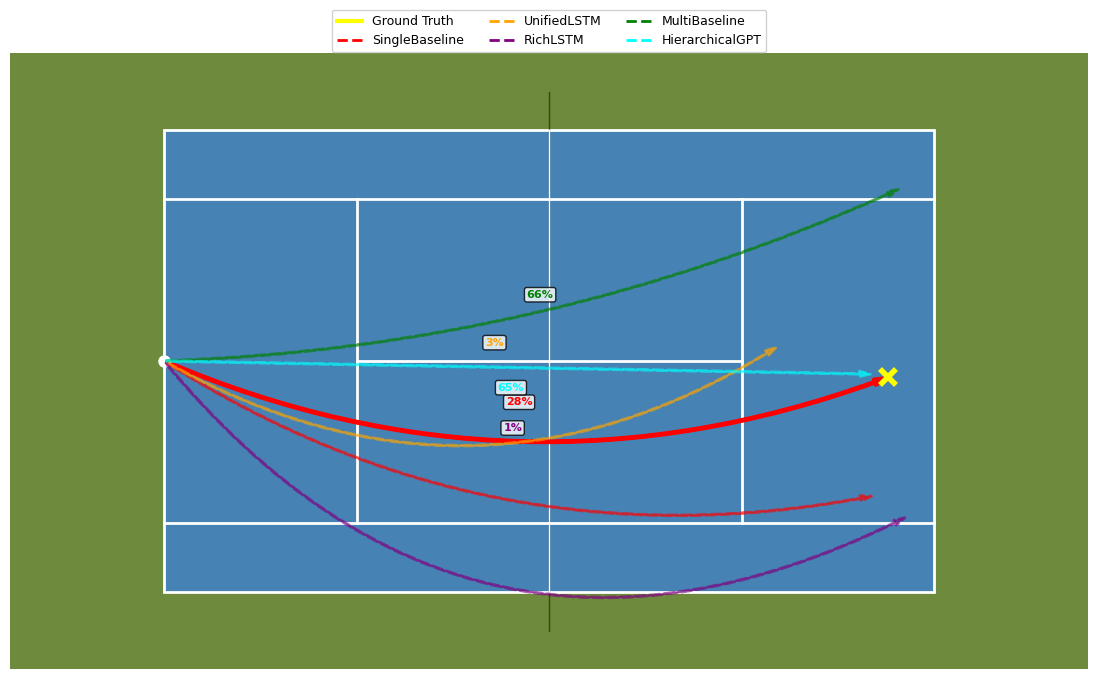

In [32]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyArrowPatch
from matplotlib.lines import Line2D
import numpy as np
import random
import torch
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- 1. TENNIS LOGIC (WITH DEPTH & PHYSICS) ---
class TennisLogic:
    """Handles logic for a Left-to-Right court view with DEPTH awareness."""
    
    @staticmethod
    def decode_token(token_id, dataset):
        """
        Decodes token into: Type, Direction, and Depth.
        Supports 'f_1_9' (Type_Dir_Depth) or standard 'f1' (TypeDir).
        """
        if hasattr(dataset, 'inv_unified_vocab'):
             token_str = dataset.inv_unified_vocab.get(token_id, 'f2')
        else:
            token_str = 'f2'
            
        token_str = str(token_str).strip().lower()
        
        # Defaults
        shot_data = {'type': 'f', 'direction': '2', 'depth': '9', 'is_serve': False}

        # 1. PARSE SERVES (4, 5, 6)
        if token_str and token_str[0] in ['4', '5', '6']:
            shot_data['type'] = 's'
            shot_data['direction'] = token_str[0]
            shot_data['is_serve'] = True
            shot_data['depth'] = '7' # Serves always land in service box (Short/Mid)
            return shot_data
            
        # 2. PARSE RALLIES
        # Check for underscore format (e.g., "f_1_7")
        if '_' in token_str:
            parts = token_str.split('_')
            shot_data['type'] = parts[0]
            if len(parts) > 1: shot_data['direction'] = parts[1]
            if len(parts) > 2: shot_data['depth'] = parts[2]
        else:
            # Standard "f1" format
            shot_data['type'] = token_str[0]
            # Extract numbers for direction
            for char in token_str:
                if char in ['1', '2', '3']:
                    shot_data['direction'] = char
                    break
        
        # 3. INFER DEPTH FROM SHOT TYPE (If depth is default '9')
        # u/y = Drop shots (Very Short)
        # v/z = Volleys (Often Mid/Deep, but let's default to Mid for visual variety)
        # h/i = Half volleys (Mid)
        if shot_data['type'] in ['u', 'y']:
            shot_data['depth'] = '5' # Very short (Net is 5.0)
        elif shot_data['type'] in ['v', 'z', 'h', 'i']:
            shot_data['depth'] = '8' # Mid court
            
        return shot_data

    @staticmethod
    def get_target_coordinates(direction, depth, is_serve, hitting_from_left):
        """
        Calculates landing spot X,Y with Jitter.
        X-Axis: 0 (Left Baseline) -> 5 (Net) -> 10 (Right Baseline)
        """
        # Y-AXIS (Width 0-6)
        # 1=Right(Bottom), 2=Center, 3=Left(Top)
        base_y = 3.0
        if direction == '1':   base_y = 1.0
        elif direction == '2': base_y = 3.0
        elif direction == '3': base_y = 5.0
        elif direction == '4': base_y = 1.0 if hitting_from_left else 5.0 # Wide Serve
        elif direction == '5': base_y = 3.0 # Body
        elif direction == '6': base_y = 3.0 # T
        
        # X-AXIS (Length/Depth)
        # Determine base "Deep" landing spot
        if hitting_from_left:
            # Ball moving Left -> Right (Target x > 5)
            if is_serve:
                base_x = 7.0 # Service Line is 7.5, land slightly inside
            elif depth == '5': # Drop shot
                base_x = 5.8 # Just over net
            elif depth == '7': # Short
                base_x = 7.0 # Service line area
            elif depth == '8': # Mid
                base_x = 8.0 # No man's land
            else: # 9 / Deep
                base_x = 9.5 # Baseline area
        else:
            # Ball moving Right -> Left (Target x < 5)
            if is_serve:
                base_x = 3.0 # Service Line is 2.5
            elif depth == '5': # Drop shot
                base_x = 4.2 # Just over net
            elif depth == '7': # Short
                base_x = 3.0
            elif depth == '8': # Mid
                base_x = 2.0
            else: # 9 / Deep
                base_x = 0.5 # Baseline area

        # ADD RANDOM JITTER (So shots don't overlap perfectly)
        jitter_x = random.uniform(-0.3, 0.3)
        jitter_y = random.uniform(-0.3, 0.3)
        
        return (base_x + jitter_x, base_y + jitter_y)

# --- 2. VISUALIZATION ENGINE ---
class TennisCourtVisualizer:
    def __init__(self):
        self.fig, self.ax = plt.subplots(1, 1, figsize=(14, 8))
        self.court_color = '#4682B4'
        self.out_color = '#6E8B3D'
        self.setup_court()

    def setup_court(self):
        self.ax.clear()
        self.ax.set_xlim(-2, 12)
        self.ax.set_ylim(-1, 7)
        self.ax.set_aspect('equal')
        self.ax.axis('off')

        # Background & Court
        self.ax.add_patch(patches.Rectangle((-2, -1), 14, 8, color=self.out_color))
        self.ax.add_patch(patches.Rectangle((0, 0), 10, 6, lw=2, edgecolor='white', facecolor=self.court_color))
        
        # Lines
        # Net
        self.ax.plot([5, 5], [-0.5, 6.5], color='black', lw=1, alpha=0.5) 
        self.ax.plot([5, 5], [0, 6], color='white', lw=1)
        # Service Lines
        self.ax.plot([2.5, 2.5], [0.9, 5.1], color='white', lw=2)
        self.ax.plot([7.5, 7.5], [0.9, 5.1], color='white', lw=2)
        # Center Service
        self.ax.plot([2.5, 7.5], [3, 3], color='white', lw=2)
        # Singles Lines
        self.ax.plot([0, 10], [0.9, 0.9], color='white', lw=2)
        self.ax.plot([0, 10], [5.1, 5.1], color='white', lw=2)

        self.add_legend()

    def add_legend(self):
        legend_elements = [
            Line2D([0], [0], color='yellow', lw=3, label='Ground Truth'),
            Line2D([0], [0], color='red', lw=2, linestyle='--', label='SingleBaseline'),
            Line2D([0], [0], color='orange', lw=2, linestyle='--', label='UnifiedLSTM'),
            Line2D([0], [0], color='purple', lw=2, linestyle='--', label='RichLSTM'),
            Line2D([0], [0], color='green', lw=2, linestyle='--', label='MultiBaseline'),
            Line2D([0], [0], color='cyan', lw=2, linestyle='--', label='HierarchicalGPT')
        ]
        self.ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.08), 
                      ncol=3, framealpha=0.9, fontsize=9)

    def draw_trajectory(self, start, end, is_prediction=False, confidence=None, color='red', model_name=''):
        style = '--' if is_prediction else '-'
        alpha = 0.6 if is_prediction else 1.0
        z = 10 if is_prediction else 5
        linewidth = 2 if is_prediction else 3

        # Markers
        if not is_prediction:
            self.ax.plot(start[0], start[1], 'o', color='white', zorder=z+1, markersize=8)
            self.ax.plot(end[0], end[1], 'x', color='yellow', markersize=12, markeredgewidth=4, zorder=z+1)
        
        # Curvature - vary curvature for different models to avoid overlap
        rad_offset = {'SingleBaseline': 0, 'UnifiedLSTM': 0.1, 'RichLSTM': 0.2, 
                     'MultiBaseline': -0.1, 'HierarchicalGPT': -0.2}
        base_rad = 0.2 if start[0] < end[0] else -0.2
        rad = base_rad + rad_offset.get(model_name, 0)
        
        arrow = FancyArrowPatch(start, end, connectionstyle=f"arc3,rad={rad}", 
                                arrowstyle="Simple, tail_width=0.5, head_width=4, head_length=8",
                                color=color, linestyle=style, alpha=alpha, zorder=z, linewidth=linewidth)
        self.ax.add_patch(arrow)
        
        if is_prediction and confidence is not None:
            # Offset text positions to avoid overlap
            text_offset = {'SingleBaseline': (0, 0.3), 'UnifiedLSTM': (0.3, 0.1), 
                          'RichLSTM': (-0.3, 0.1), 'MultiBaseline': (0.1, -0.3), 
                          'HierarchicalGPT': (-0.1, -0.3)}
            
            mid_x = (start[0] + end[0]) / 2
            mid_y = (start[1] + end[1]) / 2
            offset = text_offset.get(model_name, (0, 0))
            label_x = mid_x + offset[0]
            label_y = mid_y + offset[1]
            
            self.ax.text(label_x, label_y, f"{int(confidence)}%", color=color, fontsize=8, fontweight='bold',
                        ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, pad=0.2))

# --- 3. CONTROLLER ---
class TennisRallyDemo:
    def __init__(self, models, datasets):
        self.models = models
        self.datasets = datasets
        
        # fallback vocabs in case the dataset object doesn't have them
        self.fallback_vocabs = {
            'type': {k: v for v, k in enumerate(['<pad>', '<unk>', 'serve', 'f', 'b', 'r', 's', 'v', 'z', 'o', 'p', 'u', 'y', 'l', 'm', 'h', 'i', 'j', 'k', 't', 'q', 'special', 'let'])},
            'dir': {k: v for v, k in enumerate(['<pad>', '0', '1', '2', '3'])},
            'depth': {k: v for v, k in enumerate(['<pad>', '0', '7', '8', '9'])}
        }
        
        # Use the first dataset for rally selection
        self.main_dataset = list(datasets.values())[0] if datasets else None
        self.test_indices = list(range(min(1000, len(self.main_dataset)))) if self.main_dataset else []
        
        self.viz = TennisCourtVisualizer()
        
        self.current_rally_idx = None
        self.step_idx = 0
        self.valid_indices = []
        
        self.ball_pos = (0, 3) 
        self.hitting_from_left = True 
        
        # Model colors
        self.model_colors = {
            'SingleBaseline': 'red',
            'UnifiedLSTM': 'orange', 
            'RichLSTM': 'purple',
            'MultiBaseline': 'green',
            'HierarchicalGPT': 'cyan'
        }
        
        self.setup_ui()
        
    def setup_ui(self):
        self.out_info = widgets.Output()
        self.out_viz = widgets.Output()
        
        self.btn_load = widgets.Button(description='🎾 New Rally', button_style='success')
        self.btn_next = widgets.Button(description='▶️ Next Shot', button_style='primary')
        
        # Model selection checkboxes
        self.model_checks = {}
        for model_name in self.models.keys():
            if self.models[model_name] is not None:
                self.model_checks[model_name] = widgets.Checkbox(value=True, description=model_name)
        
        self.btn_load.on_click(self.load_rally)
        self.btn_next.on_click(self.next_step)
        
        model_box = widgets.HBox(list(self.model_checks.values()))
        control_box = widgets.HBox([self.btn_load, self.btn_next])
        
        display(widgets.VBox([
            widgets.HTML("<h3>🎾 Tennis Shot Prediction Demo - All Models Comparison</h3>"),
            widgets.HTML("<b>Select Models to Compare:</b>"),
            model_box,
            control_box,
            widgets.HBox([self.out_info, self.out_viz])
        ]))
        self.load_rally(None)

    def _get_input_seq(self, data):
        """Helper to get input sequence regardless of key name"""
        if 'input' in data: return data['input']
        elif 'x_seq' in data: return data['x_seq']
        # Fallback: assume first value is input if dictionary
        return list(data.values())[0]

    def load_rally(self, b):
        if not self.main_dataset:
            with self.out_info:
                clear_output(wait=True)
                print("❌ No datasets available")
            return
            
        self.current_rally_idx = random.choice(self.test_indices)
        rally_data = self.main_dataset[self.current_rally_idx]
        
        try:
            seq = self._get_input_seq(rally_data)
            self.valid_indices = (seq != 0).nonzero(as_tuple=True)[0].tolist()
            
            if len(self.valid_indices) < 2:
                self.load_rally(None)
                return

            self.step_idx = 0
            self.ball_pos = (0, 3) 
            self.hitting_from_left = True
            self.update_visualization()
        except KeyError as e:
            with self.out_info:
                print(f"❌ Error loading rally: {e}")

    def next_step(self, b):
        if self.step_idx >= len(self.valid_indices) - 1:
            with self.out_info: 
                clear_output(wait=True)
                print("🏁 Rally Finished! Click 'New Rally'")
            return
            
        # Update physics start position from previous shot result
        prev_idx = self.valid_indices[self.step_idx]
        rally_data = self.main_dataset[self.current_rally_idx]
        seq = self._get_input_seq(rally_data)
        prev_token = seq[prev_idx].item()
        
        prev_info = TennisLogic.decode_token(prev_token, self.main_dataset)
        
        target_x, target_y = TennisLogic.get_target_coordinates(
            prev_info['direction'], prev_info['depth'], prev_info['is_serve'], self.hitting_from_left
        )
        self.ball_pos = (target_x, target_y)
        self.hitting_from_left = not self.hitting_from_left
        
        self.step_idx += 1
        self.update_visualization()

    def get_model_prediction(self, model_name, model, dataset, data, curr_idx):
        if model is None:
            return None, 0
            
        try:
            with torch.no_grad():
                model.eval()
                
                # --- 1. PREPARE INPUTS ---
                inputs = {}
                x_c = data['context'].unsqueeze(0).to(DEVICE)
                
                # --- CASE A: HierarchicalGPT ---
                if 'Hierarchical' in model_name:
                    # FIX 1: Check if decomposed inputs exist. If not, generate them on fly? 
                    # Ideally, data comes from the specific dataset.
                    if 'x_type' in data:
                        inputs['x_z'] = data['x_dir'].unsqueeze(0).to(DEVICE)
                        inputs['x_t'] = data['x_type'].unsqueeze(0).to(DEVICE)
                    else:
                        # Fallback: We are using a dataset that wasn't decomposed.
                        # We return None or try to run fallback logic (omitted for brevity)
                        return None, 0

                    inputs['x_c'] = x_c
                    
                    # FIX 2: Handle Player IDs (Int vs Tensor crash)
                    s_id = data['x_s_id']
                    r_id = data['x_r_id']
                    
                    # Convert int to tensor if strictly int
                    if isinstance(s_id, int): s_id = torch.tensor([s_id])
                    if isinstance(r_id, int): r_id = torch.tensor([r_id])
                    
                    # Ensure dimensionality [Batch]
                    if s_id.dim() == 0: s_id = s_id.unsqueeze(0)
                    if r_id.dim() == 0: r_id = r_id.unsqueeze(0)
                        
                    inputs['x_s'] = s_id.to(DEVICE)
                    inputs['x_r'] = r_id.to(DEVICE)
                    
                    # Forward pass
                    l_dir, l_depth, l_type = model(**inputs)

                    t = min(self.step_idx, l_type.size(1) - 1)
                    return self._process_multi_head_output(l_type[:, t], l_dir[:, t], l_depth[:, t], dataset)
                    
                # --- CASE B: RichLSTM ---
                elif 'Rich' in model_name and 'x_type' in data:
                    inputs['x_type'] = data['x_type'].unsqueeze(0).to(DEVICE)
                    inputs['x_dir'] = data['x_dir'].unsqueeze(0).to(DEVICE)
                    inputs['x_depth'] = data['x_depth'].unsqueeze(0).to(DEVICE)
                    inputs['x_s_id'] = data['x_s_id'].unsqueeze(0).to(DEVICE)
                    inputs['x_r_id'] = data['x_r_id'].unsqueeze(0).to(DEVICE)
                    inputs['x_context'] = x_c
                    
                    logits = model(**inputs)
                    if self.step_idx < logits.size(1): pred_logits = logits[0, self.step_idx]
                    else: pred_logits = logits[0, -1]
                        
                    probs = torch.softmax(pred_logits, dim=0)
                    conf, pred_id = probs.max(dim=0)
                    pred_info = TennisLogic.decode_token(pred_id.item(), dataset)
                    return pred_info, conf.item() * 100
                    
                # --- CASE C: MultiBaseline ---
                elif 'Multi' in model_name:
                    x_seq = self._get_input_seq(data).unsqueeze(0).to(DEVICE)
                    l_type, l_dir, l_depth = model(x_seq, x_c)
                    t = min(self.step_idx, l_type.size(1) - 1)
                    return self._process_multi_head_output(l_type[:, t], l_dir[:, t], l_depth[:, t], dataset)
                    
                # --- CASE D: Standard Models ---
                else:
                    x_seq = self._get_input_seq(data).unsqueeze(0).to(DEVICE)
                    logits = model(x_seq, x_c)
                    
                    if self.step_idx < logits.size(1):
                        pred_logits = logits[0, self.step_idx]
                    else:
                        pred_logits = logits[0, -1]
                        
                    probs = torch.softmax(pred_logits, dim=0)
                    conf, pred_id = probs.max(dim=0)
                    pred_info = TennisLogic.decode_token(pred_id.item(), dataset)
                    return pred_info, conf.item() * 100
                
        except Exception as e:
            # Uncomment to debug specific crashes
            # print(f"Error with {model_name}: {e}") 
            return None, 0

    def update_visualization(self):
        # 1. GROUND TRUTH
        data = self.main_dataset[self.current_rally_idx]
        curr_idx = self.valid_indices[self.step_idx] if self.step_idx < len(self.valid_indices) else self.valid_indices[-1]
        
        seq = self._get_input_seq(data)
        token_id = seq[curr_idx].item()
            
        shot_info = TennisLogic.decode_token(token_id, self.main_dataset)
        
        target_pos = TennisLogic.get_target_coordinates(
            shot_info['direction'], shot_info['depth'], shot_info['is_serve'], self.hitting_from_left
        )

        # 2. PREDICTIONS
        predictions = {}
        for model_name, checkbox in self.model_checks.items():
            if checkbox.value and self.models[model_name] is not None:
                # Use the specific dataset for this model
                model_dataset = self.datasets.get(model_name, self.main_dataset)
                
                # Fetch data item safely
                try: 
                    model_data = model_dataset[self.current_rally_idx]
                except: 
                    model_data = data 

                pred_info, conf = self.get_model_prediction(
                    model_name, 
                    self.models[model_name], 
                    model_dataset, 
                    model_data,
                    curr_idx
                )
                
                if pred_info:
                    predictions[model_name] = (pred_info, conf)

        # 3. DRAW
        with self.out_viz:
            clear_output(wait=True)
            self.viz.setup_court()
            
            # Ground Truth
            self.viz.draw_trajectory(self.ball_pos, target_pos, is_prediction=False)
            
            # Predictions
            for model_name, (pred_info, conf) in predictions.items():
                pred_target_pos = TennisLogic.get_target_coordinates(
                    pred_info['direction'], pred_info['depth'], pred_info['is_serve'], self.hitting_from_left
                )
                color = self.model_colors.get(model_name, 'gray')
                self.viz.draw_trajectory(self.ball_pos, pred_target_pos, is_prediction=True, 
                                        confidence=conf, color=color, model_name=model_name)
            
            display(self.viz.fig)
            
        # 4. INFO
        with self.out_info:
            clear_output(wait=True)
            print(f"🎾 Rally: {self.current_rally_idx} | Step: {self.step_idx + 1}/{len(self.valid_indices)}")
            print(f"🎯 Ground Truth: {shot_info['type'].upper()} (Dir {shot_info['direction']}, Depth {shot_info['depth']})")
            print("="*40)
            
            for model_name, (pred_info, conf) in predictions.items():
                d_match = "✅" if (pred_info['direction'] == shot_info['direction']) else "❌"
                t_match = "✅" if (pred_info['type'] == shot_info['type']) else "❌"
                print(f"{model_name}:")
                print(f"  Pred: {pred_info['type'].upper()} (D:{pred_info['direction']}, L:{pred_info['depth']})")
                print(f"  Conf: {int(conf)}% | Dir:{d_match} Typ:{t_match}")
                print()
    
    
    def _process_multi_head_output(self, l_type, l_dir, l_depth, dataset):
        """Robust helper to process outputs from multi-head models"""
        # l_type, l_dir, l_depth: [1, V]
        p_type  = torch.softmax(l_type[0], dim=0)
        p_dir   = torch.softmax(l_dir[0], dim=0)
        p_depth = torch.softmax(l_depth[0], dim=0)

        conf_t, id_t = p_type.max(0)
        conf_d, id_d = p_dir.max(0)
        conf_dp, id_dp = p_depth.max(0)
        
        # FIX 3: USE FALLBACK VOCAB IF DATASET DOESN'T HAVE IT
        if hasattr(dataset, 'type_vocab'):
            inv_type = {v: k for k, v in dataset.type_vocab.items()}
            inv_dir = {v: k for k, v in dataset.dir_vocab.items()}
            inv_depth = {v: k for k, v in dataset.depth_vocab.items()}
        else:
            inv_type = {v: k for k, v in self.fallback_vocabs['type'].items()}
            inv_dir = {v: k for k, v in self.fallback_vocabs['dir'].items()}
            inv_depth = {v: k for k, v in self.fallback_vocabs['depth'].items()}
        
        str_type = inv_type.get(id_t.item(), 'f')
        str_dir = inv_dir.get(id_d.item(), '2')
        str_depth = inv_depth.get(id_dp.item(), '9')
        
        pred_info = {
            'type': str_type,
            'direction': str_dir,
            'depth': str_depth,
            'is_serve': False
        }
        
        if str_type == 'serve':
            pred_info['type'] = 's'
            pred_info['is_serve'] = True
            
        conf = (conf_t + conf_d + conf_dp) / 3 * 100
        return pred_info, conf
    def update_visualization(self):
        # 1. GROUND TRUTH (Keep using main dataset for the physics/ground truth)
        data = self.main_dataset[self.current_rally_idx]
        curr_idx = self.valid_indices[self.step_idx] if self.step_idx < len(self.valid_indices) else self.valid_indices[-1]
        
        seq = self._get_input_seq(data)
        token_id = seq[curr_idx].item()
            
        shot_info = TennisLogic.decode_token(token_id, self.main_dataset)
        
        target_pos = TennisLogic.get_target_coordinates(
            shot_info['direction'], shot_info['depth'], shot_info['is_serve'], self.hitting_from_left
        )

        # 2. PREDICTIONS FROM ALL SELECTED MODELS
        predictions = {}
        for model_name, checkbox in self.model_checks.items():
            if checkbox.value and self.models[model_name] is not None:
                # A. Get the specific dataset for this model
                model_dataset = self.datasets.get(model_name, self.main_dataset)
                
                # B. CRITICAL FIX: Fetch the data sample from the MODEL'S dataset, 
                # not the main dataset. This ensures keys like 'x_type' exist for RichLSTM.
                try:
                    model_data = model_dataset[self.current_rally_idx]
                except IndexError:
                    # Fallback if datasets have different lengths
                    model_data = data 

                pred_info, conf = self.get_model_prediction(
                    model_name, 
                    self.models[model_name], 
                    model_dataset, 
                    model_data,  # <--- Pass specific data here
                    curr_idx
                )
                
                if pred_info:
                    predictions[model_name] = (pred_info, conf)
                else:
                    # Optional: Print why it failed to the console for debugging
                    print(f"DEBUG: {model_name} returned None prediction.")

        # 3. VISUALIZATION
        with self.out_viz:
            clear_output(wait=True)
            self.viz.setup_court()
            
            # Draw ground truth
            self.viz.draw_trajectory(self.ball_pos, target_pos, is_prediction=False)
            
            # Draw all model predictions
            for model_name, (pred_info, conf) in predictions.items():
                pred_target_pos = TennisLogic.get_target_coordinates(
                    pred_info['direction'], pred_info['depth'], pred_info['is_serve'], self.hitting_from_left
                )
                color = self.model_colors.get(model_name, 'gray')
                self.viz.draw_trajectory(self.ball_pos, pred_target_pos, is_prediction=True, 
                                        confidence=conf, color=color, model_name=model_name)
            
            display(self.viz.fig)
            
        # 4. INFO DISPLAY
        with self.out_info:
            clear_output(wait=True)
            print(f"🎾 Rally: {self.current_rally_idx} | Step: {self.step_idx + 1}/{len(self.valid_indices)}")
            print(f"🎯 Ground Truth: {shot_info['type'].upper()} (Dir {shot_info['direction']}, Depth {shot_info['depth']})")
            print("="*40)
            
            # Show all model predictions
            for model_name, (pred_info, conf) in predictions.items():
                direction_match = "✅" if (pred_info['direction'] == shot_info['direction']) else "❌"
                type_match = "✅" if (pred_info['type'] == shot_info['type']) else "❌"
                print(f"{model_name}:")
                print(f"  Prediction: {pred_info['type'].upper()} (Dir {pred_info['direction']}, Depth {pred_info['depth']})")
                print(f"  Confidence: {int(conf)}% | Direction: {direction_match} | Type: {type_match}")
                print()
    
    
    def _process_multi_head_output(self, l_type, l_dir, l_depth, dataset):
        """Helper to process outputs from multi-head models"""
        idx = self.step_idx if self.step_idx < l_type.size(1) else -1
        
        # l_type, l_dir, l_depth: [1, V]
        p_type  = torch.softmax(l_type[0], dim=0)
        p_dir   = torch.softmax(l_dir[0], dim=0)
        p_depth = torch.softmax(l_depth[0], dim=0)

        
        conf_t, id_t = p_type.max(0)
        conf_d, id_d = p_dir.max(0)
        conf_dp, id_dp = p_depth.max(0)
        
        # Invert vocabs to get string values
        inv_type = {v: k for k, v in dataset.type_vocab.items()}
        inv_dir = {v: k for k, v in dataset.dir_vocab.items()}
        inv_depth = {v: k for k, v in dataset.depth_vocab.items()}
        
        str_type = inv_type.get(id_t.item(), 'f')
        str_dir = inv_dir.get(id_d.item(), '2')
        str_depth = inv_depth.get(id_dp.item(), '9')
        
        # Construct pred_info
        pred_info = {
            'type': str_type,
            'direction': str_dir,
            'depth': str_depth,
            'is_serve': False
        }
        
        if str_type == 'serve':
            pred_info['type'] = 's'
            pred_info['is_serve'] = True
            
        conf = (conf_t + conf_d + conf_dp) / 3 * 100
        return pred_info, conf

 
# Create the demo with all loaded models
def extract_model(model_var):
    """Helper to extract model from tuple if needed"""
    if isinstance(model_var, tuple):
        return model_var[0]  # Return just the model from (model, optimizer, checkpoint)
    return model_var

available_models = {
    'SingleBaseline': extract_model(globals().get('singleBaseline', None)),
    'UnifiedLSTM': extract_model(globals().get('singleModel1', None)), 
    'RichLSTM': extract_model(globals().get('singleModel2', None)),
    'MultiBaseline': extract_model(globals().get('multiBaseline', None)),
    'HierarchicalGPT': extract_model(globals().get('multiModel', None))
}

available_datasets = {
    'SingleBaseline': globals().get('datasetSingleBaseline', None),
    'UnifiedLSTM': globals().get('datasetSingleModel1', None),
    'RichLSTM': globals().get('datasetSingleModel2', None), 
    'MultiBaseline': globals().get('datasetMultiBaseline', None),
    'HierarchicalGPT': globals().get('datasetMultiModel', None)
}

# Filter out None models and datasets
working_models = {k: v for k, v in available_models.items() if v is not None}
working_datasets = {k: v for k, v in available_datasets.items() if v is not None}

print(f"🚀 Available models for demo: {list(working_models.keys())}")

if working_models and working_datasets:
    demo = TennisRallyDemo(working_models, working_datasets)
else:
    print("❌ No models available. Please run the model loading cells first.")

In [28]:
# Test HierarchicalGPT model directly
print("🔍 Testing HierarchicalGPT model...")

# Check if model exists
if 'multiModel' in globals() and multiModel is not None:
    # multiModel is a tuple (model, optimizer, checkpoint)
    if isinstance(multiModel, tuple):
        actual_model = multiModel[0]
        print(f"✅ Model loaded: {type(actual_model)} (from tuple)")
        print(f"   Device: {next(actual_model.parameters()).device}")
    else:
        actual_model = multiModel
        print(f"✅ Model loaded: {type(actual_model)}")
        print(f"   Device: {next(actual_model.parameters()).device}")
    
    # Check dataset
    if 'datasetMultiModel' in globals():
        print(f"✅ Dataset loaded: {type(datasetMultiModel)}")
        print(f"   Dataset length: {len(datasetMultiModel)}")
        
        # Get a sample from the dataset
        sample_idx = 0
        sample = datasetMultiModel[sample_idx]
        print(f"\n📊 Sample data keys: {list(sample.keys())}")
        
        for key, value in sample.items():
            if isinstance(value, torch.Tensor):
                print(f"   {key}: {value.shape} ({value.dtype})")
            else:
                print(f"   {key}: {type(value)} = {value}")
        
        # Test model inference
        try:
            with torch.no_grad():
                actual_model.eval()
                
                # Prepare inputs
                inputs = {}
                inputs['x_c'] = sample['context'].unsqueeze(0).to(DEVICE)
                
                # Check for required inputs
                if 'x_dir' in sample and 'x_type' in sample:
                    inputs['x_z'] = sample['x_dir'].unsqueeze(0).to(DEVICE)
                    inputs['x_t'] = sample['x_type'].unsqueeze(0).to(DEVICE)
                    print(f"\n✅ Using decomposed inputs:")
                    print(f"   x_z (directions): {inputs['x_z'].shape}")
                    print(f"   x_t (types): {inputs['x_t'].shape}")
                else:
                    # Create dummy inputs
                    seq_len = 30
                    inputs['x_z'] = torch.ones(1, seq_len, dtype=torch.long).to(DEVICE)
                    inputs['x_t'] = torch.zeros(1, seq_len, dtype=torch.long).to(DEVICE)
                    print(f"\n⚠️ Using dummy inputs (decomposed data not found):")
                    print(f"   x_z (directions): {inputs['x_z'].shape}")
                    print(f"   x_t (types): {inputs['x_t'].shape}")
                
                # Player IDs
                s_id = sample.get('x_s_id', 1)
                r_id = sample.get('x_r_id', 2)
                
                if not isinstance(s_id, torch.Tensor):
                    s_id = torch.tensor(s_id)
                if not isinstance(r_id, torch.Tensor):
                    r_id = torch.tensor(r_id)
                    
                if s_id.dim() == 0: s_id = s_id.unsqueeze(0)
                if r_id.dim() == 0: r_id = r_id.unsqueeze(0)
                
                inputs['x_s'] = s_id.to(DEVICE)
                inputs['x_r'] = r_id.to(DEVICE)
                
                print(f"   x_s (server): {inputs['x_s'].shape}")
                print(f"   x_r (receiver): {inputs['x_r'].shape}")
                print(f"   x_c (context): {inputs['x_c'].shape}")
                
                # Forward pass - FIXED: use actual_model instead of multiModel
                print(f"\n🚀 Running forward pass...")
                l_dir, l_depth, l_type = actual_model(**inputs)
                
                print(f"✅ Model outputs:")
                print(f"   l_dir (directions): {l_dir.shape}")
                print(f"   l_depth (depths): {l_depth.shape}")  
                print(f"   l_type (types): {l_type.shape}")
                
                # Test prediction at step 0
                step = 0
                if step < l_type.size(1):
                    type_logits = l_type[0, step]
                    dir_logits = l_dir[0, step]
                    depth_logits = l_depth[0, step]
                    
                    type_probs = torch.softmax(type_logits, dim=0)
                    dir_probs = torch.softmax(dir_logits, dim=0)
                    depth_probs = torch.softmax(depth_logits, dim=0)
                    
                    type_conf, type_id = type_probs.max(0)
                    dir_conf, dir_id = dir_probs.max(0)
                    depth_conf, depth_id = depth_probs.max(0)
                    
                    print(f"\n🎯 Predictions at step {step}:")
                    print(f"   Type ID: {type_id.item()} (conf: {type_conf.item():.3f})")
                    print(f"   Dir ID: {dir_id.item()} (conf: {dir_conf.item():.3f})")
                    print(f"   Depth ID: {depth_id.item()} (conf: {depth_conf.item():.3f})")
                    
                    # Check vocabularies
                    if hasattr(datasetMultiModel, 'type_vocab'):
                        inv_type = {v: k for k, v in datasetMultiModel.type_vocab.items()}
                        inv_dir = {v: k for k, v in datasetMultiModel.dir_vocab.items()}
                        inv_depth = {v: k for k, v in datasetMultiModel.depth_vocab.items()}
                        
                        type_str = inv_type.get(type_id.item(), '?')
                        dir_str = inv_dir.get(dir_id.item(), '?')
                        depth_str = inv_depth.get(depth_id.item(), '?')
                        
                        print(f"\n📝 Decoded predictions:")
                        print(f"   Type: {type_str}")
                        print(f"   Direction: {dir_str}")
                        print(f"   Depth: {depth_str}")
                    else:
                        print(f"\n⚠️ No vocabularies found in dataset")
                        
                else:
                    print(f"\n⚠️ Step {step} >= sequence length {l_type.size(1)}")
                
        except Exception as e:
            print(f"\n❌ Error during model inference:")
            print(f"   {type(e).__name__}: {e}")
            import traceback
            traceback.print_exc()
            
    else:
        print("❌ Dataset not found")
else:
    print("❌ Model not loaded")

🔍 Testing HierarchicalGPT model...
✅ Model loaded: <class 'models.models.HierarchicalCristianGPT'> (from tuple)
   Device: cpu
✅ Dataset loaded: <class 'dataset.HierarchicalTennisDataset'>
   Dataset length: 962968

📊 Sample data keys: ['x_seq', 'context', 'x_s_id', 'x_r_id', 'y_target', 'x_type', 'x_dir', 'x_depth', 'y_type', 'y_dir', 'y_depth']
   x_seq: torch.Size([30]) (torch.int64)
   context: torch.Size([10]) (torch.float32)
   x_s_id: torch.Size([]) (torch.int64)
   x_r_id: torch.Size([]) (torch.int64)
   y_target: torch.Size([30]) (torch.int64)
   x_type: torch.Size([30]) (torch.int64)
   x_dir: torch.Size([30]) (torch.int64)
   x_depth: torch.Size([30]) (torch.int64)
   y_type: torch.Size([30]) (torch.int64)
   y_dir: torch.Size([30]) (torch.int64)
   y_depth: torch.Size([30]) (torch.int64)

✅ Using decomposed inputs:
   x_z (directions): torch.Size([1, 30])
   x_t (types): torch.Size([1, 30])
   x_s (server): torch.Size([1])
   x_r (receiver): torch.Size([1])
   x_c (context)

In [29]:
# Investigate depth prediction issue
print("🔍 Analyzing depth predictions...")

# Check the depth vocabulary
print(f"\n📚 Depth vocabulary in dataset:")
if hasattr(datasetMultiModel, 'depth_vocab'):
    print(f"   Full depth vocab: {datasetMultiModel.depth_vocab}")
    inv_depth = {v: k for k, v in datasetMultiModel.depth_vocab.items()}
    print(f"   Inverse depth vocab: {inv_depth}")
else:
    print("   ❌ No depth_vocab found")

# Check the actual depth logits and probabilities
print(f"\n🎯 Current depth prediction analysis:")
print(f"   Raw depth logits: {depth_logits}")
print(f"   Depth probabilities: {depth_probs}")
print(f"   Max probability: {depth_conf.item():.4f}")
print(f"   Predicted depth ID: {depth_id.item()}")
print(f"   Decoded depth: '{depth_str}'")

# Check distribution across all depth classes
print(f"\n📊 All depth probabilities:")
for i, prob in enumerate(depth_probs):
    depth_label = inv_depth.get(i, f"ID_{i}")
    print(f"   Depth {i} ('{depth_label}'): {prob.item():.4f}")

# Test multiple samples to see if depth is always 8
print(f"\n🔬 Testing multiple samples for depth diversity...")
depth_predictions = []

for test_idx in range(5):
    try:
        test_sample = datasetMultiModel[test_idx]
        test_inputs = {
            'x_c': test_sample['context'].unsqueeze(0).to(DEVICE),
            'x_z': test_sample['x_dir'].unsqueeze(0).to(DEVICE),
            'x_t': test_sample['x_type'].unsqueeze(0).to(DEVICE),
            'x_s': test_sample['x_s_id'].unsqueeze(0).to(DEVICE) if hasattr(test_sample['x_s_id'], 'unsqueeze') else torch.tensor([test_sample['x_s_id']]).to(DEVICE),
            'x_r': test_sample['x_r_id'].unsqueeze(0).to(DEVICE) if hasattr(test_sample['x_r_id'], 'unsqueeze') else torch.tensor([test_sample['x_r_id']]).to(DEVICE)
        }
        
        with torch.no_grad():
            test_l_dir, test_l_depth, test_l_type = actual_model(**test_inputs)
            test_depth_probs = torch.softmax(test_l_depth[0, 0], dim=0)
            test_depth_conf, test_depth_id = test_depth_probs.max(0)
            test_depth_str = inv_depth.get(test_depth_id.item(), '?')
            depth_predictions.append((test_depth_id.item(), test_depth_str, test_depth_conf.item()))
            
            print(f"   Sample {test_idx}: Depth ID={test_depth_id.item()}, Label='{test_depth_str}', Conf={test_depth_conf.item():.3f}")
            
    except Exception as e:
        print(f"   Sample {test_idx}: Error - {e}")

# Summary
unique_depths = set([pred[0] for pred in depth_predictions])
print(f"\n📈 Summary:")
print(f"   Unique depth IDs predicted: {unique_depths}")
print(f"   Total unique depths: {len(unique_depths)}")

if len(unique_depths) == 1:
    print("   ⚠️ WARNING: Model is predicting the same depth for all samples!")
    print("   This could indicate:")
    print("     1. Model bias towards most common depth class")
    print("     2. Insufficient training on depth diversity")
    print("     3. Vocabulary mapping issues")
    print("     4. Dataset imbalance")
else:
    print("   ✅ Model shows depth prediction diversity")

# Check the actual ground truth depth distribution in a few samples
print(f"\n🎲 Ground truth depth distribution in dataset samples:")
ground_truth_depths = []
for i in range(10):
    try:
        sample = datasetMultiModel[i]
        if 'x_depth' in sample:
            # For multi-head models, check actual depth labels
            depth_seq = sample['x_depth']
            unique_depths_in_seq = torch.unique(depth_seq[depth_seq != 0])  # Exclude padding
            for depth_id in unique_depths_in_seq:
                depth_label = inv_depth.get(depth_id.item(), '?')
                ground_truth_depths.append((depth_id.item(), depth_label))
                
    except Exception as e:
        continue

if ground_truth_depths:
    gt_depth_counts = {}
    for depth_id, depth_label in ground_truth_depths:
        key = f"{depth_id} ('{depth_label}')"
        gt_depth_counts[key] = gt_depth_counts.get(key, 0) + 1
    
    print("   Ground truth depth distribution:")
    for depth_key, count in gt_depth_counts.items():
        print(f"     {depth_key}: {count} occurrences")
else:
    print("   ❌ Could not analyze ground truth depths")

🔍 Analyzing depth predictions...

📚 Depth vocabulary in dataset:
   Full depth vocab: {'<pad>': 0, '0': 1, '7': 2, '8': 3, '9': 4}
   Inverse depth vocab: {0: '<pad>', 1: '0', 2: '7', 3: '8', 4: '9'}

🎯 Current depth prediction analysis:
   Raw depth logits: tensor([-9.4379,  1.5743,  0.3950,  0.5252, -0.4881])
   Depth probabilities: tensor([9.2434e-06, 5.6026e-01, 1.7227e-01, 1.9623e-01, 7.1237e-02])
   Max probability: 0.5603
   Predicted depth ID: 1
   Decoded depth: '0'

📊 All depth probabilities:
   Depth 0 ('<pad>'): 0.0000
   Depth 1 ('0'): 0.5603
   Depth 2 ('7'): 0.1723
   Depth 3 ('8'): 0.1962
   Depth 4 ('9'): 0.0712

🔬 Testing multiple samples for depth diversity...
   Sample 0: Depth ID=1, Label='0', Conf=0.560
   Sample 1: Depth ID=1, Label='0', Conf=0.557
   Sample 2: Depth ID=1, Label='0', Conf=0.354
   Sample 3: Depth ID=1, Label='0', Conf=0.463
   Sample 4: Depth ID=1, Label='0', Conf=0.567

📈 Summary:
   Unique depth IDs predicted: {1}
   Total unique depths: 1
   ⚠

In [39]:
# Investigate SingleBaseline prediction issue
print("🔍 Analyzing SingleBaseline predictions...")

# Test if SingleBaseline changes predictions across different steps
if 'singleBaseline' in globals() and singleBaseline is not None:
    print(f"✅ SingleBaseline model available: {type(singleBaseline)}")
    
    # Test with a few different rally samples and steps
    test_rally_idx = 42  # Fixed rally for consistency
    test_data = datasetSingleBaseline[test_rally_idx]
    
    print(f"\n🎾 Testing rally {test_rally_idx}:")
    print(f"   Available keys: {list(test_data.keys())}")
    
    # Get the correct input key (different datasets use different keys)
    input_key = None
    if 'input' in test_data:
        input_key = 'input'
    elif 'x_seq' in test_data:
        input_key = 'x_seq'
    else:
        # Fallback: use first tensor key
        for key, value in test_data.items():
            if isinstance(value, torch.Tensor) and len(value.shape) == 1:
                input_key = key
                break
    
    if input_key is None:
        print("   ❌ Could not find input sequence key!")
    else:
        print(f"   Using input key: '{input_key}'")
        print(f"   Input sequence shape: {test_data[input_key].shape}")
        print(f"   Context shape: {test_data['context'].shape}")
        
        # Get valid indices for this rally
        seq = test_data[input_key]
        valid_indices = (seq != 0).nonzero(as_tuple=True)[0].tolist()
        print(f"   Valid sequence positions: {valid_indices[:10]}...")  # Show first 10
        # Only test steps where we actually have data!
        indices_to_test = valid_indices[:5] 
        
        if not indices_to_test:
            print("⚠️ No valid tokens found in this sequence (all padding?)")
        else:
            print(f"\n🔬 Testing predictions at VALID steps (Indices {indices_to_test}):")
        
        # Test predictions at different steps
        print(f"\n🔬 Testing predictions at different steps:")
        
        predictions_by_step = []
        for step_idx in range(min(5, len(valid_indices))):  # Test first 5 steps
            try:
                with torch.no_grad():
                    singleBaseline.eval()
                    
                    # Prepare inputs
                    x_seq = test_data[input_key].unsqueeze(0).to(DEVICE)
                    x_c = test_data['context'].unsqueeze(0).to(DEVICE)
                    
                    # Forward pass
                    logits = singleBaseline(x_seq, x_c)
                    
                    if step_idx < logits.size(1):
                        pred_logits = logits[0, step_idx]
                    else:
                        pred_logits = logits[0, -1]
                        
                    probs = torch.softmax(pred_logits, dim=0)
                    conf, pred_id = probs.max(dim=0)
                    
                    # Decode prediction
                    if hasattr(datasetSingleBaseline, 'inv_unified_vocab'):
                        pred_token = datasetSingleBaseline.inv_unified_vocab.get(pred_id.item(), '?')
                    else:
                        pred_token = f"ID_{pred_id.item()}"
                    
                    predictions_by_step.append((step_idx, pred_id.item(), pred_token, conf.item()))
                    
                    print(f"   Step {step_idx}: Token ID={pred_id.item()}, Token='{pred_token}', Conf={conf.item():.3f}")
                    
            except Exception as e:
                print(f"   Step {step_idx}: Error - {e}")
                
        # Check if all predictions are identical
        unique_predictions = set([pred[1] for pred in predictions_by_step])  # pred_id only
        print(f"\n📈 Analysis:")
        print(f"   Unique prediction IDs: {unique_predictions}")
        print(f"   Number of unique predictions: {len(unique_predictions)}")
        
        if len(unique_predictions) == 1:
            print("   ⚠️ WARNING: SingleBaseline predicts the same token for all steps!")
            print("   Possible causes:")
            print("     1. Model collapsed to always predict most frequent token")
            print("     2. Input sequence not changing (all zeros or same values)")
            print("     3. Model not properly trained")
            print("     4. Context information not being used")
            
            # Check if the input sequence actually changes
            print(f"\n🔍 Input sequence analysis:")
            unique_tokens_in_sequence = torch.unique(seq[seq != 0])
            print(f"   Unique tokens in input sequence: {unique_tokens_in_sequence.tolist()}")
            print(f"   Sequence diversity: {len(unique_tokens_in_sequence)} unique tokens")
            
            # Check the raw logits to see if they're actually different
            print(f"\n📊 Raw logits analysis:")
            with torch.no_grad():
                singleBaseline.eval()
                x_seq = test_data[input_key].unsqueeze(0).to(DEVICE)
                x_c = test_data['context'].unsqueeze(0).to(DEVICE)
                logits = singleBaseline(x_seq, x_c)
                
                print(f"   Logits shape: {logits.shape}")
                if len(valid_indices) >= 2:
                    step1_logits = logits[0, 0]
                    step2_logits = logits[0, 1]
                    
                    logits_diff = torch.abs(step1_logits - step2_logits).sum()
                    print(f"   Difference between step 0 and 1 logits: {logits_diff.item():.6f}")
                    
                    if logits_diff.item() < 1e-6:
                        print("   ❌ Logits are identical across steps - model is not learning temporal patterns!")
                    else:
                        print("   ✅ Logits do change between steps")
                        
                    # Show top predictions for each step
                    print(f"\n   Top 3 predictions for step 0:")
                    probs1 = torch.softmax(step1_logits, dim=0)
                    top_probs1, top_ids1 = probs1.topk(3)
                    for i, (prob, token_id) in enumerate(zip(top_probs1, top_ids1)):
                        token = datasetSingleBaseline.inv_unified_vocab.get(token_id.item(), f"ID_{token_id.item()}")
                        print(f"     {i+1}. {token} ({prob.item():.3f})")
                    
                    print(f"\n   Top 3 predictions for step 1:")
                    probs2 = torch.softmax(step2_logits, dim=0)
                    top_probs2, top_ids2 = probs2.topk(3)
                    for i, (prob, token_id) in enumerate(zip(top_probs2, top_ids2)):
                        token = datasetSingleBaseline.inv_unified_vocab.get(token_id.item(), f"ID_{token_id.item()}")
                        print(f"     {i+1}. {token} ({prob.item():.3f})")
                        
        else:
            print("   ✅ SingleBaseline shows prediction diversity across steps")
            
        # Test with a different rally to see if it's rally-specific
        print(f"\n🔄 Testing with different rally (idx 123):")
        try:
            test_data2 = datasetSingleBaseline[123]
            with torch.no_grad():
                singleBaseline.eval()
                # Use the same input key we found earlier
                x_seq2 = test_data2[input_key].unsqueeze(0).to(DEVICE)
                x_c2 = test_data2['context'].unsqueeze(0).to(DEVICE)
                logits2 = singleBaseline(x_seq2, x_c2)
                
                pred_logits2 = logits2[0, 0]
                probs2 = torch.softmax(pred_logits2, dim=0)
                conf2, pred_id2 = probs2.max(dim=0)
                
                token2 = datasetSingleBaseline.inv_unified_vocab.get(pred_id2.item(), f"ID_{pred_id2.item()}")
                print(f"   Prediction: Token ID={pred_id2.item()}, Token='{token2}', Conf={conf2.item():.3f}")
                
                if pred_id2.item() == predictions_by_step[0][1]:
                    print("   ⚠️ Same prediction as previous rally - model may be stuck!")
                else:
                    print("   ✅ Different prediction for different rally")
                    
        except Exception as e:
            print(f"   Error testing different rally: {e}")
        
else:
    print("❌ SingleBaseline model not available")

🔍 Analyzing SingleBaseline predictions...
✅ SingleBaseline model available: <class 'models.models.SimpleUnifiedBaseline'>

🎾 Testing rally 42:
   Available keys: ['x_seq', 'context', 'x_s_id', 'x_r_id', 'y_target']
   Using input key: 'x_seq'
   Input sequence shape: torch.Size([30])
   Context shape: torch.Size([10])
   Valid sequence positions: [28, 29]...

🔬 Testing predictions at VALID steps (Indices [28, 29]):

🔬 Testing predictions at different steps:
   Step 0: Token ID=4, Token='Serve_4', Conf=0.427
   Step 1: Token ID=4, Token='Serve_4', Conf=0.427

📈 Analysis:
   Unique prediction IDs: {4}
   Number of unique predictions: 1
   ⚠️ WARNING: SingleBaseline predicts the same token for all steps!
   Possible causes:
     1. Model collapsed to always predict most frequent token
     2. Input sequence not changing (all zeros or same values)
     3. Model not properly trained
     4. Context information not being used

🔍 Input sequence analysis:
   Unique tokens in input sequence: [4